<a href="https://colab.research.google.com/github/Tarwish2005/Paddy-disease-classifier/blob/main/Disease_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/paddy-disease-classification'
od.download(dataset_url)
#key for kaggle
{"username":"tarwishsahayata","key":"0d0a89148c8e0385bf522bc1294d9a4b"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [ ]:
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import cv2
from torchvision.utils import save_image
import os
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision import models
import tqdm
import pickle

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 50
lr = 0.001

In [ ]:
NORMALIZATION_STATS = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [ ]:
train_dir = "./paddy-disease-classification/train_images"


shear_intensity = 0.2
zoom_factor = 0.2
width_shift = 0.05
height_shift = 0.05

train_transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomRotation(degrees=5),
    T.RandomAffine(degrees=0, translate=(width_shift, height_shift), shear=shear_intensity, scale=(1 - zoom_factor, 1 + zoom_factor)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*NORMALIZATION_STATS)
]
)
train = ImageFolder(train_dir,transform=train_transform)

In [ ]:
total_size = len(train)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation
train_ds, val_ds = random_split(train, [train_size, val_size])

train_dl = DataLoader(train_ds , BATCH_SIZE , shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds , BATCH_SIZE , shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


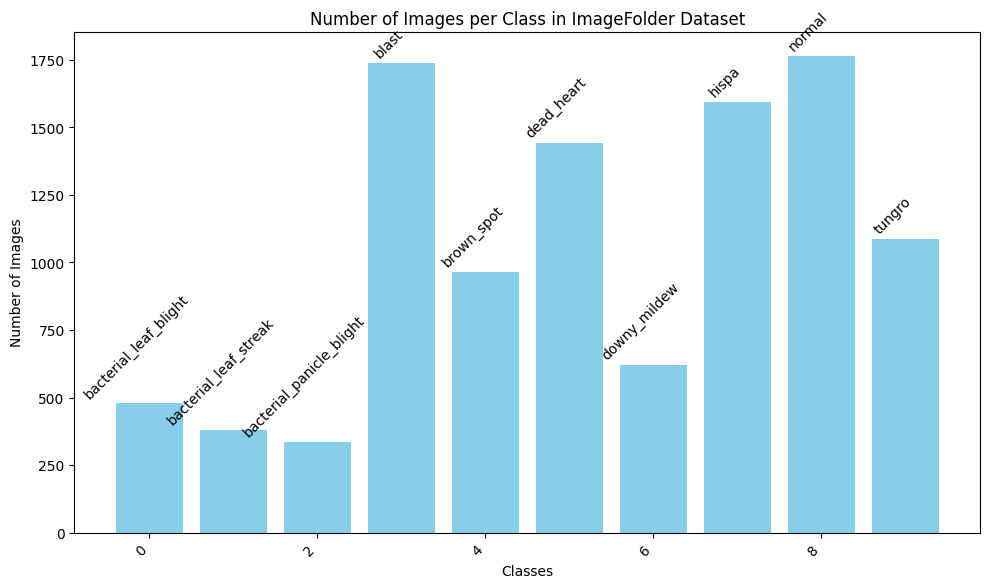

In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from collections import Counter

class_labels = [class_idx for _, class_idx in train.imgs]
label_counts = Counter(class_labels)
class_names = train.classes

classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color='skyblue')

for bar, class_name in zip(bars, class_names):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 20, class_name, rotation=45, ha='center')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in ImageFolder Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
def denorm(img_tensors):
    return img_tensors * NORMALIZATION_STATS[1][0] + NORMALIZATION_STATS[0][0]

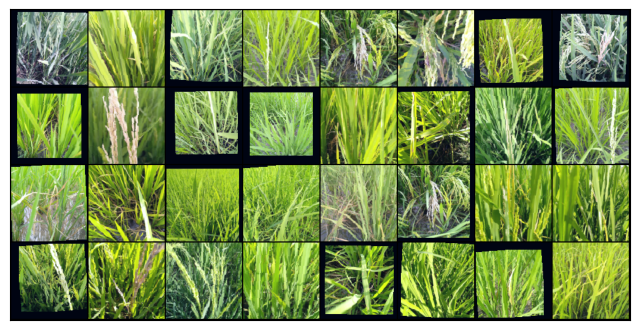

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])  # Remove axis ticks for better visualization
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))  # Display images in an 8x8 grid

# This function retrieves a batch from the DataLoader and uses show_images to display it
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break  # Only display one batch

# Visualize a batch of training images
show_batch(train_dl)

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Determine the device to use
device = get_default_device()

# Move the model to the selected device
model = to_device(model, device)

# train_dl = DeviceDataLoader(train_dl, device)
# val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model,val_loader):
    model.eval()
    loss = []
    acc = []
    for image ,label in val_loader:
        image, label = image.to(device), label.to(device)
        out = model(image)
        l = F.cross_entropy(out, label)
        a = accuracy(out, label)
        loss.append(l)
        acc.append(a)

    loss = torch.Tensor(loss).mean().item()
    acc = torch.Tensor(acc).mean().item()
    return loss, acc


In [ ]:
import tqdm

# Initialize logs
logs = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, EPOCHS + 1):
    model.train()  # Set the model to training mode
    losses = []

    for image, label in tqdm.tqdm(train_dl):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()  # Reset gradients
        output = model(image)  # Forward pass
        loss = criterion(output, label)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        losses.append(loss.item())  # Record training loss

    # Calculate the average training loss
    train_loss = torch.tensor(losses).mean().item()

    # Evaluate the model on the validation set
    val_loss, val_acc = evaluate(model, val_dl)

    # Print the training and validation results
    print(f"Epoch [{epoch}/{EPOCHS}] - Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

    # Record logs
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)





100%|██████████| 261/261 [00:41<00:00,  6.29it/s]


Epoch [1/50] - Train loss: 1.3313 | Val loss: 1.1215 | Val accuracy: 0.6340


100%|██████████| 261/261 [00:38<00:00,  6.81it/s]


Epoch [2/50] - Train loss: 0.8773 | Val loss: 0.7957 | Val accuracy: 0.7287


100%|██████████| 261/261 [00:41<00:00,  6.24it/s]


Epoch [3/50] - Train loss: 0.6708 | Val loss: 0.9469 | Val accuracy: 0.6998


100%|██████████| 261/261 [00:39<00:00,  6.67it/s]


Epoch [4/50] - Train loss: 0.5398 | Val loss: 0.5520 | Val accuracy: 0.8267


100%|██████████| 261/261 [00:40<00:00,  6.47it/s]


Epoch [5/50] - Train loss: 0.4672 | Val loss: 0.5511 | Val accuracy: 0.8243


100%|██████████| 261/261 [00:40<00:00,  6.46it/s]


Epoch [6/50] - Train loss: 0.4069 | Val loss: 0.5692 | Val accuracy: 0.8239


100%|██████████| 261/261 [00:39<00:00,  6.64it/s]


Epoch [7/50] - Train loss: 0.3357 | Val loss: 0.4949 | Val accuracy: 0.8532


100%|██████████| 261/261 [00:38<00:00,  6.77it/s]


Epoch [8/50] - Train loss: 0.2973 | Val loss: 0.4295 | Val accuracy: 0.8722


100%|██████████| 261/261 [00:40<00:00,  6.38it/s]


Epoch [9/50] - Train loss: 0.2768 | Val loss: 0.3183 | Val accuracy: 0.9067


100%|██████████| 261/261 [00:37<00:00,  6.89it/s]


Epoch [10/50] - Train loss: 0.2586 | Val loss: 0.3142 | Val accuracy: 0.9081


100%|██████████| 261/261 [00:39<00:00,  6.63it/s]


Epoch [11/50] - Train loss: 0.2272 | Val loss: 0.2999 | Val accuracy: 0.9134


100%|██████████| 261/261 [00:39<00:00,  6.55it/s]


Epoch [12/50] - Train loss: 0.2166 | Val loss: 0.2894 | Val accuracy: 0.9134


100%|██████████| 261/261 [00:39<00:00,  6.61it/s]


Epoch [13/50] - Train loss: 0.1960 | Val loss: 0.3702 | Val accuracy: 0.9015


100%|██████████| 261/261 [00:38<00:00,  6.81it/s]


Epoch [14/50] - Train loss: 0.1834 | Val loss: 0.5315 | Val accuracy: 0.8783


100%|██████████| 261/261 [00:42<00:00,  6.20it/s]


Epoch [15/50] - Train loss: 0.1807 | Val loss: 0.3100 | Val accuracy: 0.9205


100%|██████████| 261/261 [00:40<00:00,  6.49it/s]


Epoch [16/50] - Train loss: 0.1785 | Val loss: 0.3206 | Val accuracy: 0.9152


100%|██████████| 261/261 [00:39<00:00,  6.60it/s]


Epoch [17/50] - Train loss: 0.1765 | Val loss: 0.2395 | Val accuracy: 0.9323


100%|██████████| 261/261 [00:41<00:00,  6.28it/s]


Epoch [18/50] - Train loss: 0.1284 | Val loss: 0.2993 | Val accuracy: 0.9105


100%|██████████| 261/261 [00:40<00:00,  6.48it/s]


Epoch [19/50] - Train loss: 0.1385 | Val loss: 0.2778 | Val accuracy: 0.9271


100%|██████████| 261/261 [00:37<00:00,  6.89it/s]


Epoch [20/50] - Train loss: 0.1339 | Val loss: 0.3194 | Val accuracy: 0.9200


100%|██████████| 261/261 [00:39<00:00,  6.56it/s]


Epoch [21/50] - Train loss: 0.1635 | Val loss: 0.2911 | Val accuracy: 0.9285


100%|██████████| 261/261 [00:38<00:00,  6.73it/s]


Epoch [22/50] - Train loss: 0.1256 | Val loss: 0.3423 | Val accuracy: 0.9110


100%|██████████| 261/261 [00:42<00:00,  6.21it/s]


Epoch [23/50] - Train loss: 0.0958 | Val loss: 0.2471 | Val accuracy: 0.9342


100%|██████████| 261/261 [00:37<00:00,  6.87it/s]


Epoch [24/50] - Train loss: 0.1106 | Val loss: 0.2517 | Val accuracy: 0.9375


100%|██████████| 261/261 [00:40<00:00,  6.45it/s]


Epoch [25/50] - Train loss: 0.1582 | Val loss: 0.2399 | Val accuracy: 0.9323


100%|██████████| 261/261 [00:40<00:00,  6.41it/s]


Epoch [26/50] - Train loss: 0.0928 | Val loss: 0.2086 | Val accuracy: 0.9484


100%|██████████| 261/261 [00:40<00:00,  6.51it/s]


Epoch [27/50] - Train loss: 0.1065 | Val loss: 0.2403 | Val accuracy: 0.9389


100%|██████████| 261/261 [00:39<00:00,  6.59it/s]


Epoch [28/50] - Train loss: 0.1235 | Val loss: 0.2538 | Val accuracy: 0.9408


100%|██████████| 261/261 [00:41<00:00,  6.31it/s]


Epoch [29/50] - Train loss: 0.1200 | Val loss: 0.2158 | Val accuracy: 0.9484


100%|██████████| 261/261 [00:38<00:00,  6.70it/s]


Epoch [30/50] - Train loss: 0.1222 | Val loss: 0.2334 | Val accuracy: 0.9536


100%|██████████| 261/261 [00:39<00:00,  6.67it/s]


Epoch [31/50] - Train loss: 0.1405 | Val loss: 0.2614 | Val accuracy: 0.9370


100%|██████████| 261/261 [00:40<00:00,  6.45it/s]


Epoch [32/50] - Train loss: 0.1056 | Val loss: 0.2413 | Val accuracy: 0.9413


100%|██████████| 261/261 [00:39<00:00,  6.62it/s]


Epoch [33/50] - Train loss: 0.0704 | Val loss: 0.1998 | Val accuracy: 0.9508


100%|██████████| 261/261 [00:38<00:00,  6.73it/s]


Epoch [34/50] - Train loss: 0.1023 | Val loss: 0.2855 | Val accuracy: 0.9370


100%|██████████| 261/261 [00:41<00:00,  6.33it/s]


Epoch [35/50] - Train loss: 0.0877 | Val loss: 0.1883 | Val accuracy: 0.9612


100%|██████████| 261/261 [00:39<00:00,  6.62it/s]


Epoch [36/50] - Train loss: 0.0674 | Val loss: 0.2319 | Val accuracy: 0.9531


100%|██████████| 261/261 [00:39<00:00,  6.58it/s]


Epoch [37/50] - Train loss: 0.0749 | Val loss: 0.2144 | Val accuracy: 0.9437


100%|██████████| 261/261 [00:40<00:00,  6.39it/s]


Epoch [38/50] - Train loss: 0.0715 | Val loss: 0.4402 | Val accuracy: 0.9062


100%|██████████| 261/261 [00:39<00:00,  6.61it/s]


Epoch [39/50] - Train loss: 0.0783 | Val loss: 0.1875 | Val accuracy: 0.9583


100%|██████████| 261/261 [00:39<00:00,  6.53it/s]


Epoch [40/50] - Train loss: 0.0830 | Val loss: 0.2389 | Val accuracy: 0.9508


100%|██████████| 261/261 [00:41<00:00,  6.26it/s]


Epoch [41/50] - Train loss: 0.1378 | Val loss: 0.2836 | Val accuracy: 0.9366


100%|██████████| 261/261 [00:39<00:00,  6.63it/s]


Epoch [42/50] - Train loss: 0.0603 | Val loss: 0.2246 | Val accuracy: 0.9517


100%|██████████| 261/261 [00:38<00:00,  6.84it/s]


Epoch [43/50] - Train loss: 0.0539 | Val loss: 0.2078 | Val accuracy: 0.9583


100%|██████████| 261/261 [00:41<00:00,  6.23it/s]


Epoch [44/50] - Train loss: 0.0848 | Val loss: 0.2459 | Val accuracy: 0.9465


100%|██████████| 261/261 [00:39<00:00,  6.62it/s]


Epoch [45/50] - Train loss: 0.0811 | Val loss: 0.3532 | Val accuracy: 0.9186


100%|██████████| 261/261 [00:39<00:00,  6.58it/s]


Epoch [46/50] - Train loss: 0.0545 | Val loss: 0.2002 | Val accuracy: 0.9579


100%|██████████| 261/261 [00:41<00:00,  6.36it/s]


Epoch [47/50] - Train loss: 0.0726 | Val loss: 0.2312 | Val accuracy: 0.9498


100%|██████████| 261/261 [00:39<00:00,  6.65it/s]


Epoch [48/50] - Train loss: 0.0806 | Val loss: 0.2223 | Val accuracy: 0.9484


100%|██████████| 261/261 [00:39<00:00,  6.55it/s]


Epoch [49/50] - Train loss: 0.0546 | Val loss: 0.1762 | Val accuracy: 0.9602


100%|██████████| 261/261 [00:39<00:00,  6.65it/s]


Epoch [50/50] - Train loss: 0.0338 | Val loss: 0.1895 | Val accuracy: 0.9673
